In [3]:
%matplotlib inline
import pandas as pd
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import learning_curve


kernels = ['linear', 'rbf', 'poly']

def run_svm_with_feature_selection(results, X_encoded, Y, file_name, k_features=10):
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X_encoded, Y, test_size=0.2, random_state=42)

    best_model = None
    best_score = -1
    best_kernel = ""
    best_pipeline = None
    feature_names = X_encoded.columns

    for kernel in kernels:
        print(f"\nRunning GridSearch for kernel: {kernel}")

        # Define param grid based on kernel
        if kernel == 'linear':
            param_grid = {
                'svm__C': [0.01, 0.1, 1, 10],
            }
        elif kernel == 'rbf':
            param_grid = {
                'svm__C': [0.01, 0.1, 1, 10],
                'svm__gamma': [1e-3, 1e-2, 0.1],
            }
        elif kernel == 'poly':
            param_grid = {
                'svm__C': [0.01, 0.1, 1, 10],
                'svm__gamma': [1e-3, 0.01, 0.1, 1],
                'svm__degree': [2, 3, 4],
                'svm__coef0': [0, 0.5, 1],
            }

        # Build pipeline
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('svm', SVC(kernel=kernel))
        ])

        # Apply Grid Search using F1 score
        grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1_micro', n_jobs=-1)
        grid_search.fit(X_train, y_train)

        best_estimator = grid_search.best_estimator_

        # Predict
        y_pred = best_estimator.predict(X_test)

        # Evaluate
        f1 = f1_score(y_test, y_pred, average="micro")
        print(f"Best Params for {kernel}: {grid_search.best_params_}")
        print(f"F1 Score ({kernel}): {f1}")
        cm = confusion_matrix(y_test, y_pred)

        if f1 > best_score:
            best_score = f1
            best_model = best_estimator.named_steps['svm']
            best_pipeline = best_estimator
            best_kernel = kernel

        results[kernel] = (f1, cm, best_estimator)

    if best_pipeline is not None:

        # Plot learning curves for each best estimator per kernel
        for kernel_name, (_, _, best_estimator) in results.items():
            print(f"\nPlotting learning curve for kernel: {kernel_name}")
            plot_learning_curves(best_estimator, X_train, y_train, kernel_name)
            
        print("\nBest overall kernel:", best_kernel)
        disp = ConfusionMatrixDisplay(confusion_matrix=results[best_kernel][1])
        disp.plot(cmap=plt.cm.Blues)
        plt.title(f'Confusion Matrix: {best_kernel}')
        plt.savefig("bankruptcy_svm_best_confusion_matrix" , bbox_inches='tight')

        plt.show()


def plot_learning_curves(estimator, X, y, kernel_name, scoring='f1_macro'):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator,
        X,
        y,
        cv=5,
        scoring=scoring,
        train_sizes=np.linspace(0.1, 1.0, 10),
        n_jobs=-1,
        shuffle=True,
        random_state=42
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    plt.figure(figsize=(8, 5))
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')
    plt.title(f'Learning Curve: SVM ({kernel_name} kernel)')
    plt.xlabel('Training Examples')
    plt.ylabel('F1 Score (Macro)')
    plt.legend(loc='best')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("bankruptcy_svm_" + kernel_name + "_learning_curve" , bbox_inches='tight')
    plt.show()


def graph_svm_results(results_arr, file_name_base, results_names=None):
    plt.figure(figsize=(6, 5))

    i = 0
    for r_dict in results_arr:
        x_arr = []
        y_arr = []
        for k, v in r_dict.items():
            x_arr.append(k)
            y_arr.append(v[0])  # F1 score now

        if results_names:
            plt.plot(x_arr, y_arr, marker='o', linestyle='-', linewidth=2, label=results_names[i])
            i += 1
        else:
            plt.plot(x_arr, y_arr, marker='o', linestyle='-', linewidth=2)

    plt.title('F1 Score vs Kernel')
    plt.xlabel('Kernel')
    plt.ylabel('F1 Score')

    if results_names:
        plt.legend()

    plt.tight_layout()
    plt.savefig(file_name_base, bbox_inches='tight')
    plt.show()



Running GridSearch for kernel: linear
Best Params for linear: {'svm__C': 0.01}
F1 Score (linear): 0.9626099706744868

Running GridSearch for kernel: rbf
Best Params for rbf: {'svm__C': 0.01, 'svm__gamma': 0.001}
F1 Score (rbf): 0.9626099706744868

Running GridSearch for kernel: poly
Best Params for poly: {'svm__C': 0.1, 'svm__coef0': 0.5, 'svm__degree': 2, 'svm__gamma': 0.001}
F1 Score (poly): 0.9626099706744868

Plotting learning curve for kernel: linear


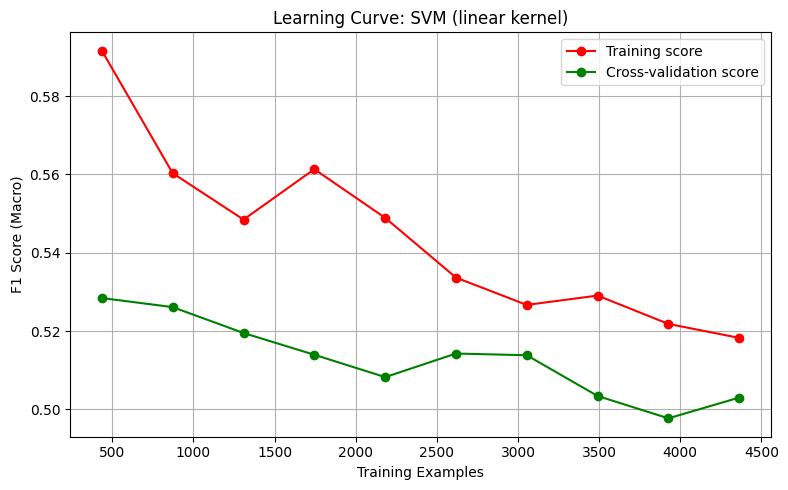


Plotting learning curve for kernel: rbf


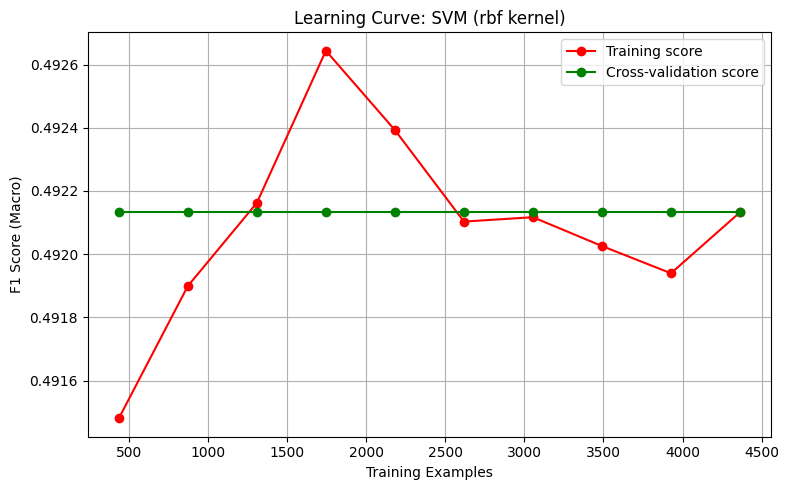


Plotting learning curve for kernel: poly


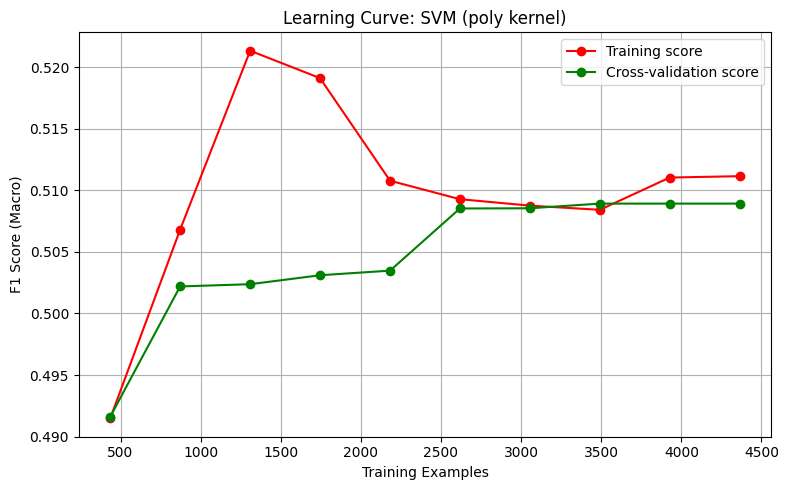


Best overall kernel: linear


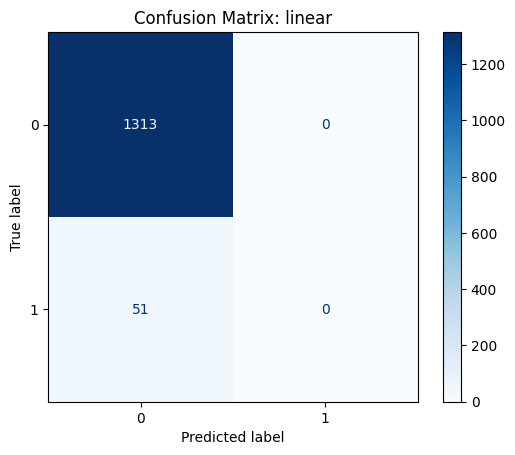

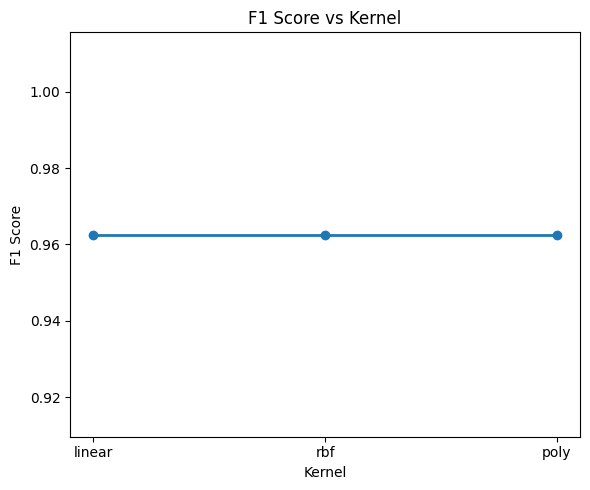

In [4]:
import pandas as pd

df = pd.read_csv('bankruptcy_data.csv')

X = df.drop(['Bankrupt?', ' Net Income Flag', ' Liability-Assets Flag'], axis=1)
Y = df['Bankrupt?']

# Run the algorithm
full_results = {}
run_svm_with_feature_selection(full_results, X, Y, "bankrupcy_svm_")
graph_svm_results([full_results], "bankrupcy_svm_all")